# Electricity balancing as a market equilibrium

This code belong to the publication Electricity balancing as a market equilibrium.
Authors: Anselm Eicke, Oliver Ruhnau, and Lion Hirth

For any questions or suggestions regarding the code please contact Anselm Eicke: anselm.eicke@daad-alumni.de

# Setup

Load modules:

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import fsolve
from linearmodels import IVSystemGMM, IVGMM

%matplotlib inline
pd.set_option('display.max_columns', None)

Read preprocessed data (not all raw data can not be shared due to licence restrictions)

In [49]:
df = pd.read_pickle('data/preprocessed')

introduce control variables

In [50]:
# introduce control variables

# quarter hours
df['M_15'] = 0
df.loc[df.index.minute == 15,'M_15'] = 1

df['M_30'] = 0
df.loc[df.index.minute == 30,'M_30'] = 1

df['M_45'] = 0
df.loc[df.index.minute == 45,'M_45'] = 1

import re

# hours
for i in ['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23']:
    df[i] = 0
    df.loc[df.index.hour == int(re.findall("(\d*)", i)[1]),i] = 1

# business days
bdays = pd.bdate_range(df.index.date[1], df.index.date[-1], freq = 'B')
df['Business day'] = 0
for i in bdays:
    df.loc[df.index.date == i, 'Business day'] = 1

#months  
for i in ['M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12']:
    df[i] = 0
    df.loc[df.index.month ==  int(re.findall("(\d*)", i)[1]),i] = 1

#summer / winter  
df['Summer'] = 0
df.loc[(df.index.date > pd.Timestamp('2018-06-20')) & (df.index.date < pd.Timestamp('2018-09-22')),'Summer'] = 1
df.loc[(df.index.date > pd.Timestamp('2019-06-20')) & (df.index.date < pd.Timestamp('2019-09-22')),'Summer'] = 1

df['Winter'] = 0
df.loc[(df.index.date > pd.Timestamp('2018-12-21')) & (df.index.date < pd.Timestamp('2019-03-20')),'Winter'] = 1

define the threshold value for data exclusion (changed in sensitivity analysis)

In [51]:
th = 500
df_short = df.loc[(df['system imbalance'] > th)]
df_long = df.loc[(df['system imbalance'] < -th)]
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th))]

In [52]:
df_combined.head()

,const,system imbalance,imbalance price,ID1,DA,ID1-DA,Solar DA err,Wind DA err,Load DA err,Wind ID err,IGCC,FRR_prices_POS,FRR_prices_NEG,FRR_procurement_POS,FRR_procurement_NEG,FRR_POS_S,FRR_NEG_L,const_POS,const_NEG,direction,MPV,M_15,M_30,M_45,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,Business day,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,Summer,Winter
2018-07-12 01:00:00+02:00,1.0,797.624,69.09,54.76,46.10,8.66,0.0,810.0,762.0,293.0,168.692,112.825793,6.587766,3665.0,2920.0,112.825793,0.000000,1,0,short,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2018-07-12 01:15:00+02:00,1.0,542.252,57.14,48.20,46.10,2.10,0.0,794.0,861.0,413.0,239.252,112.825793,6.587766,3665.0,2920.0,112.825793,0.000000,1,0,short,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2018-07-12 01:30:00+02:00,1.0,546.888,64.31,44.53,46.10,-1.57,0.0,813.0,789.0,494.0,54.704,112.825793,6.587766,3665.0,2920.0,112.825793,0.000000,1,0,short,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2018-07-12 06:45:00+02:00,1.0,-530.936,22.26,53.57,51.05,2.52,205.0,-1795.0,1198.0,-692.0,-427.540,109.666729,4.016823,3665.0,2930.0,0.000000,4.016823,0,1,long,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2018-07-12 08:00:00+02:00,1.0,632.132,64.65,48.62,58.90,-10.28,877.0,-1999.0,350.0,130.0,235.268,110.305954,-3.535697,3665.0,3018.0,110.305954,0.000000,1,0,short,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0


# Relevance of instruments

testing the relevance of instruments through OLS regressions

In [53]:
def ols_regression(df, endog, exog):       
    model = sm.OLS(df[endog], df[exog])
    results = model.fit()
    print(results.summary())

In [54]:
endog = ['imbalance price']
exog = ['FRR_POS_S', 'FRR_NEG_L', 'const_POS', 'const_NEG']

ols_regression(df_combined, endog, exog)

                            OLS Regression Results                            
Dep. Variable:        imbalance price   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     1732.
Date:                Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:14:42   Log-Likelihood:                -77028.
No. Observations:               13450   AIC:                         1.541e+05
Df Residuals:                   13446   BIC:                         1.541e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FRR_POS_S      0.3072      0.008     39.282      0.0

In [55]:
endog = ['system imbalance']
exog = ['Load DA err', 'Solar DA err', 'Wind ID err', 'const_POS', 'const_NEG']  

ols_regression(df_combined, endog, exog)

                            OLS Regression Results                            
Dep. Variable:       system imbalance   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 1.491e+04
Date:                Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:14:42   Log-Likelihood:                -99947.
No. Observations:               13450   AIC:                         1.999e+05
Df Residuals:                   13445   BIC:                         1.999e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Load DA err     -0.0210      0.002    -11.899   

# Data characteristics

Parameter mean values (Table 2)

In [56]:
for indicator in ['system imbalance', 
                  'imbalance price', 
                  'ID1', 
                  'Load DA err', 
                  'Wind ID err', 
                  'Solar DA err', 
                  'FRR_POS_S', 
                  'FRR_NEG_L',
                  'IGCC']:

    print(indicator)
    print('Mean (short): ' + str(round(df_short[indicator].mean(),2)))
    print('Mean (long): ' + str(round(df_long[indicator].mean(),2)))
    print('\n')

system imbalance
Mean (short): 897.32
Mean (long): -841.26


imbalance price
Mean (short): 79.9
Mean (long): 3.22


ID1
Mean (short): 56.84
Mean (long): 29.38


Load DA err
Mean (short): -2053.09
Mean (long): -768.49


Wind ID err
Mean (short): 298.05
Mean (long): -324.95


Solar DA err
Mean (short): 177.88
Mean (long): -212.59


FRR_POS_S
Mean (short): 124.01
Mean (long): 0.0


FRR_NEG_L
Mean (short): 0.0
Mean (long): 151.56


IGCC
Mean (short): 216.21
Mean (long): -160.58




Create scatter plot of imbalance price and system imbalance (Figure 4)

In [57]:
def scatter_color(df, 
            save_path, 
            y_label='Imbalance price (€/MWh)', 
            x_label='System imbalance (MW)', 
            x='system imbalance', 
            y='imbalance price', 
            xlim=[-3000,3000], 
            xstep=10, 
            ystep=1, 
            ylim=[-300,300], 
            heat=True):
    
    fig = plt.figure(figsize=(6/1.2, 5/1.2))
    
    def get_value(df, x, y):
        try:
            return count.loc[x, y]
        except KeyError:
            return np.nan

    xlist = range(xlim[0], xlim[1]+1, xstep)
    ylist = range(ylim[0], ylim[1]+1, ystep)

    df = df.copy()
    df[x] = (df[x]/xstep).round()*xstep
    df[y] = (df[y]/ystep).round()*ystep

    count = df.groupby([x, y])[x].count().unstack()
    count = pd.concat([
        pd.Series([
            get_value(count, xi, yi)
            for xi in xlist
        ], index=xlist)
        for yi in ylist
    ], axis=1, keys=ylist)

    count = count.div(xstep * ystep)
    
    plt.pcolormesh(count.index, count.columns, count.transpose(), cmap='hot')
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    #Short and long system labels
    props = dict(facecolor='white', alpha=0) 
    fig.text(0.2, 0.93, 'Long system', fontsize=11, verticalalignment='top', bbox=props) 
    fig.text(0.5, 0.93, 'Short system', fontsize=11, verticalalignment='top', bbox=props)
    
    # number of observations
    props = dict(facecolor='white', alpha=1) 
    fig.text(0.56, 0.18, 'N = ' + str(df.shape[0]), fontsize=11, verticalalignment='top', bbox=props) 
    
    # plot colorbar
    #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    plt.colorbar(cmap='hot', shrink=0.72, aspect = 20, 
                 ticks=np.arange(0.2,1.66,.2),
                 boundaries=np.arange(.15,1.66,.02))
    
    # colorbarlabel
    props = dict(facecolor='white', alpha=0)
    fig.text(0.78, 0.86, 'Density of\nobservations\n(1 per\nMW * €/MWh)', fontsize=11, verticalalignment='center', 
        horizontalalignment = 'left', bbox=props)
   
    plt.savefig('graphs/' + save_path, dpi = 500)      

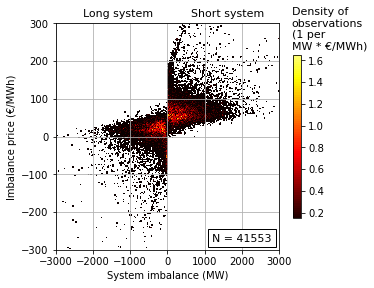

In [58]:
scatter_color(df, save_path='all_data')

# Econometric GMM Model

Define control variables

In [59]:
control_variables = ['Business day', 'M_15','M_30','M_45', 'H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23', 'M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12']

Combined system GMM estimation for short and long systems (e.g. Model 1)

In [60]:
def system_GMM_combined(df, wind = 'Wind ID err'):

    demand = ['system imbalance']
    demand_shifters = ['Load DA err', wind, 'Solar DA err', 'DA']
    supply_instruments = ['Load DA err', 'Solar DA err', wind]
    
    supply = ['imbalance price']
    supply_shifters = ['FRR_POS_S', 'FRR_NEG_L']
    demand_instruments = ['FRR_POS_S', 'FRR_NEG_L']

    equations = dict(
        imbalance_price = {
            'dependent': df[supply],
            'exog': df[supply_shifters + ['const_POS', 'const_NEG'] + control_variables], #  
            'endog': df[demand],
            'instruments': df[supply_instruments]
        },
        system_imbalance = {
            'dependent': df[demand], 
            'exog': df[demand_shifters + ['const_POS', 'const_NEG'] + control_variables], #  
            'endog': df[supply], 
            'instruments': df[demand_instruments]
        }
    )

    system_gmm = IVSystemGMM(equations, weight_type='heteroskedastic')
    results = system_gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [61]:
# Table 3 (1) Combined model
results_combined = system_GMM_combined(df_combined);

Number of iterations: 13
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.7708
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 13450   Num. Constraints:                 None
Date:                  Thu, Apr 29 2021                                         
Time:                          10:15:04                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_POS_S            0.3145     0.0675     4.6598     0.0000      0.1822

Individual system GMM estimation for short / long systems (e.g. Models 2 and 3)   

In [62]:
def system_GMM_one_direction(df, direction='POS'):

    demand = ['system imbalance']
    demand_shifters = ['Load DA err', 'Wind ID err', 'Solar DA err', 'DA']
    supply_instruments = ['Load DA err', 'Wind ID err', 'Solar DA err']
    supply = ['imbalance price']
    supply_shifters = ['FRR_prices_{}'.format(direction)]
    demand_instruments = ['FRR_prices_{}'.format(direction)]
    
    equations = dict(
        imbalance_price = {
            'dependent': df[supply],
            'exog': df[supply_shifters + ['const']  + control_variables],
            'endog': df[demand],
            'instruments': df[supply_instruments]
        },
        system_imbalance = {
            'dependent': df[demand], 
            'exog': df[demand_shifters + ['const']  + control_variables], 
            'endog': df[supply], 
            'instruments': df[demand_instruments]
        }
    )

    system_gmm = IVSystemGMM(equations, weight_type='heteroskedastic')
    results = system_gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [63]:
# Table 3 (2): short systems (significantly short systems)
results_short = system_GMM_one_direction(df_short, 'POS');

Number of iterations: 15
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:          -2.042e-05
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                  7913   Num. Constraints:                 None
Date:                  Thu, Apr 29 2021                                         
Time:                          10:15:05                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_prices_POS       0.2480     0.0709     3.4970     0.0005      0.1090

In [64]:
# Table 3 (3): long system (significantly long systems)
results_long = system_GMM_one_direction(df_long, 'NEG');

Number of iterations: 47
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:             -0.0012
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                  5537   Num. Constraints:                 None
Date:                  Thu, Apr 29 2021                                         
Time:                          10:15:06                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_prices_NEG      -0.0491     0.0255    -1.9270     0.0540     -0.0990

GMM estimation of the demand curve, i.e. no system of equations, without instruments (Model 4) 

In [65]:
def GMM_demand_combined(df):

    demand = ['system imbalance']
    demand_shifters = ['Load DA err', 'Solar DA err', 'Wind ID err']
    supply = ['imbalance price']
    supply_shifters = ['FRR_POS_S', 'FRR_NEG_L']

    dependent = df[demand]
    exog = df[demand_shifters + ['const_POS', 'const_NEG'] + control_variables]
    endog = df[supply]
    instruments = df[supply] # without instruments        

    gmm = IVGMM(dependent, exog, endog, instruments, weight_type='heteroskedastic')
    results = gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [66]:
# [4] whole period (demand)
results_demand_combined = GMM_demand_combined(df_combined);

Number of iterations: 2
                          IV-GMM Estimation Summary                           
Dep. Variable:       system imbalance   R-squared:                      0.8295
Estimator:                     IV-GMM   Adj. R-squared:                 0.8289
No. Observations:               13450   F-statistic:                 4.761e+05
Date:                Thu, Apr 29 2021   P-value (F-stat)                0.0000
Time:                        10:15:19   Distribution:                 chi2(44)
Cov. Estimator:                kernel                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Load DA err        -0.0145     0.0031    -4.6882     0.0000     -0.0205     -0.0084
Solar DA

GMM estimation of the supply curve, i.e. no system of equations, without instruments (Model 5)

In [67]:
def GMM_supply_combined(df):

    demand = ['system imbalance']
    demand_shifters = ['Load DA err', 'Solar DA err', 'Wind ID err']
    supply = ['imbalance price']
    supply_shifters = ['FRR_POS_S', 'FRR_NEG_L']  
    
    dependent = df[supply]
    exog = df[supply_shifters + ['const_POS', 'const_NEG'] + control_variables]
    endog = df[demand]
    instruments = df[demand] # with instruments: [supply_shifters]
        
    gmm = IVGMM(dependent, exog, endog, instruments, weight_type='heteroskedastic')
    results = gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [68]:
# [5] whole period (supply)
results_supply_combined = GMM_supply_combined(df_combined);

Number of iterations: 2
                          IV-GMM Estimation Summary                           
Dep. Variable:        imbalance price   R-squared:                      0.3280
Estimator:                     IV-GMM   Adj. R-squared:                 0.3259
No. Observations:               13450   F-statistic:                 7.078e+05
Date:                Thu, Apr 29 2021   P-value (F-stat)                0.0000
Time:                        10:15:33   Distribution:                 chi2(43)
Cov. Estimator:                kernel                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_POS_S            0.3325     0.1008     3.2983     0.0010      0.1349      0.5301
FRR_

# Estimated supply and demand curve

In [69]:
def scatter_curves(df, df_short, df_long,
            save_path, 
            y_label='Imbalance price (€/MWh)', 
            x_label='System imbalance (MW)', 
            x='system imbalance', 
            y='imbalance price', 
            xlim=[-3000,3000], 
            xstep=10, 
            ystep=1, 
            ylim=[-300,300], 
            heat=True):
    
    fig = plt.figure(figsize=(5/1.2, 5/1.2))
    
    def get_value(df, x, y):
        try:
            return count.loc[x, y]
        except KeyError:
            return np.nan

    xlist = range(xlim[0], xlim[1]+1, xstep)
    ylist = range(ylim[0], ylim[1]+1, ystep)

    df = df.copy()
    df[x] = (df[x]/xstep).round()*xstep
    df[y] = (df[y]/ystep).round()*ystep

    count = df.groupby([x, y])[x].count().unstack()
    count = pd.concat([
        pd.Series([
            get_value(count, xi, yi)
            for xi in xlist
        ], index=xlist)
        for yi in ylist
    ], axis=1, keys=ylist)

    count = count.div(xstep * ystep)
    
    plt.pcolormesh(count.index, count.columns, count.transpose(), cmap='pink')
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    #demand curve (short)
    cx_d = results_combined.params['system_imbalance_const_POS'] + results_combined.params['system_imbalance_Load DA err'] * df_short['Load DA err'].mean() + results_short.params['system_imbalance_Solar DA err'] * df_short['Solar DA err'].mean() + results_short.params['system_imbalance_Wind ID err'] * df_short['Wind ID err'].mean()

    c_d = (1 / results_combined.params['system_imbalance_imbalance price']) * (-cx_d)
    x_d_s = np.arange(500,3001, 500)
    y_d_s = (1 / results_combined.params['system_imbalance_imbalance price']) * x_d_s + c_d

    #supply cuve (short)
    c_s = results_combined.params['imbalance_price_const_POS'] + results_combined.params['imbalance_price_FRR_POS_S'] * df_short['FRR_POS_S'].mean()
    x_s_s = np.arange(500,3001, 500)
    y_s_s = results_combined.params['imbalance_price_system imbalance'] * x_s_s + c_s

    #demand curve (long)
    df_long = df.loc[df['system imbalance'] < -500]
    cx_d = results_combined.params['system_imbalance_const_NEG'] + results_combined.params['system_imbalance_Load DA err'] * df_long['Load DA err'].mean() + results_long.params['system_imbalance_Solar DA err'] * df_long['Solar DA err'].mean() + results_long.params['system_imbalance_Wind ID err'] * df_long['Wind ID err'].mean()

    c_d = (1 / results_combined.params['system_imbalance_imbalance price']) * (-cx_d)
    x_d_l = np.arange(-3000,0, 500)
    y_d_l = (1 / results_combined.params['system_imbalance_imbalance price']) * x_d_l + c_d

    #supply cuve (long)
    c_s = results_combined.params['imbalance_price_const_NEG'] + results_combined.params['imbalance_price_FRR_NEG_L'] * df_long['FRR_NEG_L'].mean()
    x_s_l = np.arange(-3000,0, 500)
    y_s_l = results_combined.params['imbalance_price_system imbalance'] * x_s_l + c_s

    #plot curves
    plt.plot(x_s_s,y_s_s, color = '#5B9BD5')
    plt.plot(x_s_s,y_d_s, color = '#C40022')
    plt.plot(x_s_l,y_s_l, color = '#5B9BD5')
    plt.plot(x_d_l,y_d_l, color = '#C40022')
    plt.xlim(xlim);
    plt.ylim(ylim);
    
    #Short and long system labels
    #Short and long system labels
    props = dict(facecolor='white', alpha=0) 
    fig.text(0.25, 0.925, 'Long system', fontsize=11, verticalalignment='top', bbox=props) 
    fig.text(0.64, 0.925, 'Short system', fontsize=11, verticalalignment='top', bbox=props)
  

    plt.savefig('graphs/' + save_path, dpi = 500)      

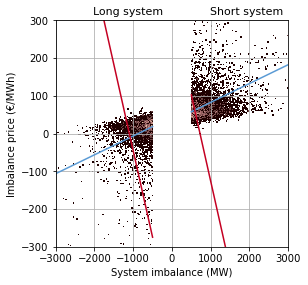

In [70]:
scatter_curves(df.loc[((df['system imbalance'] > th) | (df['system imbalance'] < -th))],
               df_short,
               df_long,
               save_path='Estimated_curves')

#  Sensitivities

In [71]:
#DA wind error
system_GMM_combined(df_combined, wind = 'Wind DA err');

Number of iterations: 22
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.7744
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 13450   Num. Constraints:                 None
Date:                  Thu, Apr 29 2021                                         
Time:                          10:16:04                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_POS_S            0.2945     0.0642     4.5876     0.0000      0.1687

In [72]:
th = 400
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th))]

In [73]:
system_GMM_combined(df_combined);

Number of iterations: 9
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.7248
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 17322   Num. Constraints:                 None
Date:                  Thu, Apr 29 2021                                         
Time:                          10:16:06                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_POS_S            0.2588     0.0513     5.0500     0.0000      0.1584 

In [74]:
th = 300
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th))]

In [75]:
system_GMM_combined(df_combined);

Number of iterations: 18
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.6680
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 22116   Num. Constraints:                 None
Date:                  Thu, Apr 29 2021                                         
Time:                          10:16:10                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_POS_S            0.1685     0.0782     2.1538     0.0313      0.0152

Heteroskedastic (Robust) Weighting (Debiased: False, Center: False)


In [76]:
th = 200
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th))]

In [77]:
system_GMM_combined(df_combined);

Number of iterations: 14
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.5989
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 27876   Num. Constraints:                 None
Date:                  Thu, Apr 29 2021                                         
Time:                          10:16:16                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_POS_S            0.1463     0.0608     2.4070     0.0161      0.0272

# Estimate effect of imbalance price on the intraday price

In [78]:
control_variables = ['Business day', 'H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23', 'M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12']

In [79]:
dependent = df_combined['ID1']
exog = df_combined[['DA', 'Load DA err', 'Solar DA err', 'Wind ID err', 'const'] + control_variables]
endog = df_combined['imbalance price']
instruments = df_combined[['FRR_POS_S', 'FRR_NEG_L']]

gmm = IVGMM(dependent, exog, endog, instruments, weight_type='heteroskedastic')
results = gmm.fit(cov_type='kernel', iter_limit=100) # robust
print('Number of iterations: ' + str(results.iterations))
print(results)

Number of iterations: 7
                          IV-GMM Estimation Summary                           
Dep. Variable:                    ID1   R-squared:                      0.5506
Estimator:                     IV-GMM   Adj. R-squared:                 0.5500
No. Observations:               27876   F-statistic:                 2.208e+05
Date:                Thu, Apr 29 2021   P-value (F-stat)                0.0000
Time:                        10:17:15   Distribution:                 chi2(40)
Cov. Estimator:                kernel                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
DA                  0.8987     0.0267     33.717     0.0000      0.8465      0.9509
Load DA 